
This notebook consist of six parts.This notebook is continued version of "The Battle of Neighborhoods (Week 1)"

1 Introduction/Business Problem

   1.a Discussion of the business problem and the audience who would be interested in this project.

2 Data Section

   2.a What data is used?
   2.b Importing Libraries
   2.c Credentials and Core location
   2.d Search for Diners within 6 miles
   2.e Location of Diners

3 Methodology Section

   3.a Removing Outlier - 
   3.b How Far are Diners from the core location
   3.c Location of all venues
   3.d How far are venues from the core location?
   3.e Rating of all Venues
   3.f Number of Tips for all Venues
   3.g Extracting Rated and Tips Venues
   3.h Final list of Venues
   3.i Clustering based on venues
   3.j Center of all clusters & Midpoint of all venues

4 Results Section

   
   4.a Top Rated Venues
   

5 Discussion Section

6 Conclusion Section

In [258]:
!pip install folium
import requests       #library to handle request
import pandas as pd   #library for data analysis
import numpy as np    #library to handle data in a vectorized manner
import random         #library for random number generation
import folium
from bs4 import BeautifulSoup
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as cm
import matplotlib.colors as colors

In [259]:
import sys
!{sys.executable} -m pip install geocoder
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [260]:
CLIENT_ID = 'MD5QZQIQEE3U4ACX5OJA500WQ4RKUD4BBGBQQ3SPQ04PUMTQ'
CLIENT_SECRET = 'HMDV1UTILXAUZE3I25OEGWKD1EN2IPPIVETYWLTMI50BUQHL' # your Foursquare Secret
VERSION = '20200611' # Foursquare API version
LIMIT = 150

address = "Parsippany Township, New Jersey, United States"

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude =location.latitude   #8.079252 # location.latitude 
longitude =location.longitude #77.5499338 # location.longitude # 

diner='Parsippany Township, New Jersey, United States location : {},{}'.format(latitude,longitude)
print(diner)
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)

Parsippany Township, New Jersey, United States location : 40.8578772,-74.4259866
Your credentails:
CLIENT_ID: MD5QZQIQEE3U4ACX5OJA500WQ4RKUD4BBGBQQ3SPQ04PUMTQ


In [266]:
#Quering for hotel & restaurant

search_query = 'diner'
radius = 10000
url= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url


'https://api.foursquare.com/v2/venues/search?client_id=MD5QZQIQEE3U4ACX5OJA500WQ4RKUD4BBGBQQ3SPQ04PUMTQ&client_secret=HMDV1UTILXAUZE3I25OEGWKD1EN2IPPIVETYWLTMI50BUQHL&ll=40.8578772,-74.4259866&v=20200611&query=diner&radius=10000&limit=150'

In [268]:
results_diner = requests.get(url).json()

In [269]:

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation

# assign relevant part of JSON to venues
venues = results_diner['response']['venues']

# tranform venues into a dataframe and merging both data
dataframe_diner = json_normalize(venues)

dataframe = pd.concat([dataframe_diner])

print("There are {} diners within approximately 8 miles of Parsippany, New Jersey.".format(dataframe.shape[0]))

There are 33 diners within approximately 8 miles of Parsippany, New Jersey.


In [234]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    
# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

  
# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#dataframe_filtered
diners_df=dataframe_filtered[['name','categories','distance','lat','lng','id']]
diners_df

,name,categories,distance,lat,lng,id
0,Rockaway Townsquare Diner,Diner,153,40.856714,-74.426975,4ebdc6c2e5fae164638f5a46
1,Empire Diner,Diner,2783,40.863335,-74.393717,4c52ec369d642d7f9030d4df
2,Brookside Diner,Diner,3681,40.825175,-74.419509,4b6a199bf964a52097c72be3
3,The Spa Diner Resraurant,Diner,4171,40.876426,-74.382928,4d50351f9d4937045e40bf39
4,Whippany Diner,Diner,4398,40.820793,-74.407954,4c0e46f6336220a10ae6cb77
5,Paul's Family Diner,Diner,4080,40.883985,-74.460021,4c1c24178b3aa5931b79985f
6,Ridgedale Diner,Diner,6729,40.827605,-74.356820,4bd1a16fa8b3a593ad04665f
7,Alexis Diner,Diner,7883,40.871479,-74.517893,4b2ce92ff964a520a3ca24e3
8,Frank's Diner,Diner,3928,40.823037,-74.418554,4ca736adb0b8236a43aba6e6
9,Whippany Diner,Diner,4411,40.820630,-74.408104,4f94b48be4b0f639262f3f26


In [270]:
dataframe_filtered=dataframe_filtered.drop(dataframe_filtered[dataframe_filtered.name =='green pond road By The Diner'].index)
diners_df=dataframe_filtered
print("So Now there are {} diners present in our analysis.".format(dataframe_filtered.shape[0]))

So Now there are 32 diners present in our analysis.


In [271]:

diners_map = folium.Map(location=[latitude, longitude], zoom_start=10) # generate map centred around Parsippany

# add a red circle marker to represent the core location i.e Parsippany
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Parsippany Township, New Jersey, United States',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.5
).add_to(diners_map)

# add the diners as blue circle markers
for lat, lng, label in zip(diners_df.lat, diners_df.lng, diners_df.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(diners_map)

# display map
diners_map

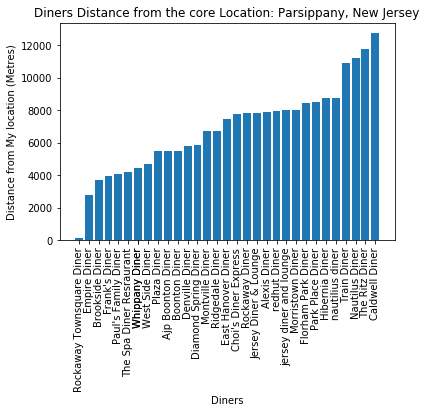

Average distance between Diners and core location is 6798 metres.


In [272]:
distance_diners_df=dataframe_filtered[['name','categories','distance','lat','lng']].sort_values('distance')

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(distance_diners_df.name))
    plt.bar(distance_diners_df.name, distance_diners_df.distance)
    plt.xlabel('Diners')
    plt.ylabel('Distance from My location (Metres)')
    plt.xticks(distance_diners_df.name, rotation = 90)
    plt.title('Diners Distance from the core Location: Parsippany, New Jersey')
    plt.show()
plot_bar_x()

print("Average distance between Diners and core location is {} metres.".format(int(sum(diners_df['distance'])/diners_df.shape[0])))

##### Few Points to Note:

- Rockaway Townsquare Diner is the closest to the core location.
- Caldwell Diner is the farthest from the core location
- The average location between Diners and core location is 6,798 meters or Approximately 4.2 miles.

exploring the closest diner

In [279]:
venue_id = '4ebdc6c2e5fae164638f5a46' # ID of Rockaway Townsquare Diner
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url

'https://api.foursquare.com/v2/venues/4ebdc6c2e5fae164638f5a46?client_id=MD5QZQIQEE3U4ACX5OJA500WQ4RKUD4BBGBQQ3SPQ04PUMTQ&client_secret=HMDV1UTILXAUZE3I25OEGWKD1EN2IPPIVETYWLTMI50BUQHL&v=20200611'

In [280]:
result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue'] 

KeyError: 'venue'

In [281]:
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

This venue has not been rated yet.


In [282]:
venue_id = '4c52ec369d642d7f9030d4df' # ID of Empire Diner
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

This venue has not been rated yet.


In [283]:
venue_id = '4b6a199bf964a52097c72be3' # ID of Brookside Diner
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

This venue has not been rated yet.


### Rating of all Venues

In [286]:

#Rating of venues
rating_df=[]

for k in range(diners_df.shape[0]):
    venue_id=diners_df.id[k]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    #print(result)
    try:
        #print(df_venues.name[k],result['response']['venue']['rating'])
        rating=result['response']['venue']['rating']
        rating_df.append(rating)
        
    except:
        #print(df_venues.name[k],'This venue has not been rated yet.')
        rating='No Rating Yet'
        rating_df.append(rating)
        rate_dict = {'Venue': diners_df.name, 'Rating': rating_df,'distance':diners_df.distance}
rate_df=pd.DataFrame(rate_dict)
rate_df

KeyError: 29

In [287]:
tips_df=[]

for k in range(diners_df.shape[0]):
    venue_id=diners_df.id[k]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    
    #print(result['response']['venue']['tips']['count'],result['response']['venue'])
    tips=result['response']['venue']['tips']['count']
    tips_df.append(tips)

KeyError: 'venue'

In [288]:

tips_dict = {'Venue': diners_df.name, 'Tips': tips_df,'distance':diners_df.distance}
tips=pd.DataFrame(tips_dict)
tips=tips.sort_values('Tips',ascending = False)
tips

ValueError: array length 0 does not match index length 32

In [289]:
# Add Tips column to Rating Dataframe
rate_df['Tips']=tips['Tips']

#Lets take values of only rated venues
only_rated_tips = rate_df[(rate_df['Rating']!='No Rating Yet') | (rate_df['Tips']!=0)]

only_rated_tips.reset_index(inplace = True,drop = True) 
only_rated_tips

NameError: name 'tips' is not defined

In [290]:
rated_list=[]
for i in range(len(only_rated_tips)):
    rated_tip_temp=only_rated_tips['Venue'][i]
    rated_list.append(rated_tip_temp)

#Masking all values present in list
mask = df_venues['name'].isin(rated_list)

final_venues = df_venues[mask]
#final_venues['location']=final_venues['lat'].astype(str).str.cat(final_venues['lng'].astype(str), sep=' - ')
final_venues.reset_index(inplace = True,drop = True) 

final_venues

NameError: name 'only_rated_tips' is not defined